In this classification model, we are going to pick 10 different books from the science fiction genre, with different authors. 

1. "Inside Earth" by Anderson,Poul William

2. "The Lost Kafoozalum" by Ashwell,Pauline

3. "Vanishing Point" by Beck,C.C.

4. "The Day Time Stopped Moving" by Buckner,Bradner

5. "Hard Guy" by Carleton,H.B.

6. "The Sound of Silence" by Constant,Barbara

7. "A Traveler in Time" by Derleth, August

8. "The Immortals" by Duncan, David

9. "The Ignoble Savages" by Smith, Evelyn E.

10. "Gladiator" by Wylie, Philip

Source: https://www.gutenberg.org/wiki/Science_Fiction_(Bookshelf)

In [3]:
import nltk
import pandas as pd
import numpy as np
from urllib import request
url_list = ["http://www.gutenberg.org/cache/epub/51184/pg51184.txt",
            "http://www.gutenberg.org/cache/epub/30427/pg30427.txt",
            "http://www.gutenberg.org/cache/epub/23868/pg23868.txt",
            "http://www.gutenberg.org/cache/epub/27053/pg27053.txt",
            "http://www.gutenberg.org/cache/epub/26855/pg26855.txt",
            "http://www.gutenberg.org/cache/epub/30283/pg30283.txt",
            "http://www.gutenberg.org/cache/epub/40953/pg40953.txt",
            "http://www.gutenberg.org/cache/epub/51801/pg51801.txt",
            "http://www.gutenberg.org/cache/epub/51413/pg51413.txt",
            "http://www.gutenberg.org/cache/epub/42914/pg42914.txt"
           ]
author_list = ["Anderson","Ashwell","Beck","Buckner","Carleton","Constant","Derleth","Duncan","Smith","Wylie"]

text_df = pd.DataFrame(columns=["Text","Author"])
text_df.head(3)

,Text,Author


In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def text_cleaner(text):
    text = re.sub("[^a-zA-Z]",' ',text)
    text = text.lower()
    text = text.split()
    lmz = WordNetLemmatizer()
    text = [lmz.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [5]:
sent_list = []
auth_list = []
for url,author in zip(url_list,author_list):
    response = request.urlopen(url)
    raw = response.read().decode('utf8')
    raw_sent = nltk.sent_tokenize(raw)
    for sent in raw_sent:
        if "START OF THIS PROJECT" in sent:
            del raw_sent[:raw_sent.index(sent)+1]
        if "END OF THIS PROJECT" in sent:
            del raw_sent[raw_sent.index(sent):]
    for sent in raw_sent:
        sent_list.append(sent)
        auth_list.append(author)

In [6]:
text_df["Text"] = sent_list
text_df["Author"] = auth_list
text_df.head(3)

,Text,Author
0,Extensive research did not uncover any evidenc...,Anderson
1,"Obviously, no conqueror wants his subjects to\...",Anderson
2,Obviously?,Anderson


In [7]:
text_df["Author"].unique()

array(['Anderson', 'Ashwell', 'Beck', 'Buckner', 'Carleton', 'Constant',
       'Derleth', 'Duncan', 'Smith', 'Wylie'], dtype=object)

In [8]:
text_df.shape

(13834, 2)

In [9]:
corpus = []
for sent in text_df["Text"]:
    sent_clean = text_cleaner(sent)
    corpus.append(sent_clean)

In [10]:
len(corpus)

13834

## K-Means Clustering

In [11]:
# max features --> 13000
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_df=0.5,
                          max_features=13000,
                          min_df=5,
                          stop_words='english',
                          use_idf=True,
                          norm=u'l2',
                          smooth_idf=True
                          )

In [40]:
X = tfidf_v.fit_transform(corpus)
y = text_df.iloc[:,1].values

In [32]:
X.shape

(13834, 2701)

In [14]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

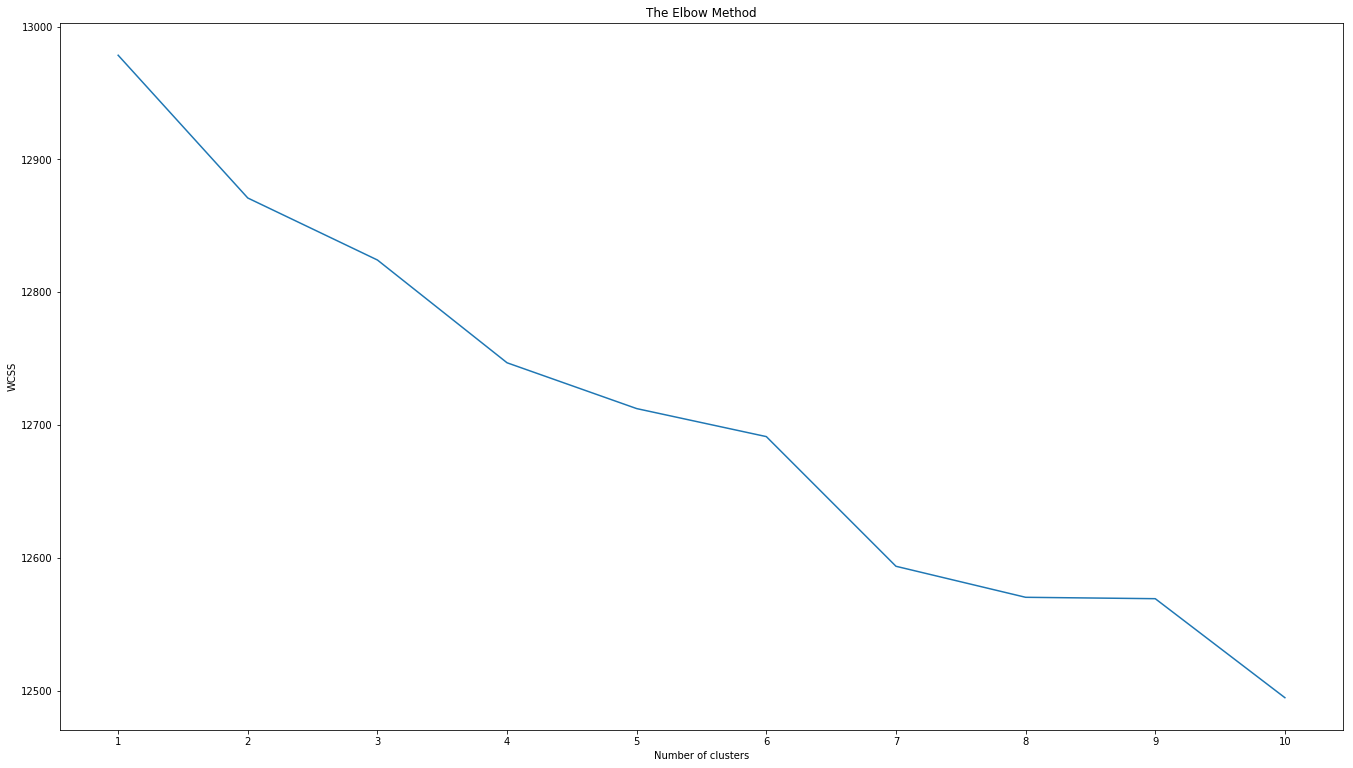

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [16]:
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [41]:
kmeans = KMeans(n_clusters=7,random_state=42)

In [42]:
y_kmeans = kmeans.fit_predict(X)

In [19]:
#set(list(y_kmeans))

In [20]:
#def ClusterIndicesNumpy(clustNum,labels_array):
    #return np.where(labels_array == clustNum)[0]

In [21]:
#clusters = {}
#for cluster in range(7):
    #if cluster not in clusters:
        #clusters[cluster] = ClusterIndicesNumpy(cluster,kmeans.labels_)

In [22]:
#for k,v in clusters.items():
    #print("Cluster {}".format(k))
    #for i in v:
        #if text_df.at[i,"Author"] in cluster_auth:
            #cluster_auth[text_df.at[i,"Author"]] += 1
        #else:
            #cluster_auth[text_df.at[i,"Author"]] = 1

In [23]:
len(y_kmeans)

13834

In [24]:
j = np.random.randint(0,13833,1)[0]

In [25]:
j

8376

In [53]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
words = tfidf_v.get_feature_names()

In [55]:
print("Top terms per cluster: ")
for i in range(6):
    print("Cluster %d:"%i)
    for ind in order_centroids[i,:10]:
        print("%s"%words[ind])

Top terms per cluster: 
Cluster 0:
like
thing
man
hugo
feel
said
men
look
day
know
Cluster 1:
hugo
looked
danner
smiled
saw
hand
walked
eye
went
little
Cluster 2:
going
thought
way
knew
bbulas
kill
war
mean
make
long
Cluster 3:
know
man
bearded
young
strong
god
time
old
came
head
Cluster 4:
time
say
thing
come
right
danner
came
hand
day
think
Cluster 5:
way
men
young
long
little
work
day
got
life
earth


In [50]:
text_cluster

{4: [<1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 7 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 5 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 3 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 0 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 7 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 7 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float64'>'
  	with 4 stored elements in Compressed Sparse Row format>,
  <1x2701 sparse matrix of type '<class 'numpy.float6

In [52]:
y_kmeans[4]

4

In [ ]:
#from sklearn.decomposition import PCA

#X_pca = PCA(2).fit_transform(X)
#X_lsa = lsa.fit_transform(X)

In [ ]:
#from sklearn.manifold import TSNE

#lsa_embed = TSNE(n_components=2,perplexity=40,verbose=2).fit_transform(X_lsa)

In [ ]:
# visualizing the clusters (only for 2-dimensional clustering, reduce 2+ dimensions using PCA)

#plt.rcParams['figure.figsize'] = (23,13)
#plt.scatter(X_pca[:,0],X_pca[:,1],c=y_kmeans)
#plt.title("Clusters")
#plt.legend()
#plt.show()